In [1]:
# finalize model and make a prediction for monthly births with random forest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import asarray
from numpy import array
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
# data_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/Data/final_data.csv"
data_path = "final_data.csv"
data_df = pd.read_csv(data_path)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27552 entries, 0 to 27551
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      27552 non-null  int64  
 1   datetime                        27552 non-null  object 
 2   Demand (MW)                     27552 non-null  float64
 3   Temperature                     27552 non-null  float64
 4   dewpoint                        27552 non-null  float64
 5   humidity                        27552 non-null  float64
 6   precipitation                   27552 non-null  float64
 7   precipprob                      27552 non-null  float64
 8   snow                            27552 non-null  float64
 9   snowdepth                       27552 non-null  float64
 10  windgust                        27552 non-null  float64
 11  windspeed                       27552 non-null  float64
 12  sealevelpressure                

In [3]:
def min_max_normalize_dataframe(df, columns):
    df_normalized = df.copy()
    for column in columns:
        if df[column].dtype in [int, float]:
            min_val = df[column].min()
            max_val = df[column].max()
            df_normalized[column] = (df[column] - min_val) / (max_val - min_val)
    return df_normalized

data_df.drop(columns=["Unnamed: 0", "datetime"], inplace=True)
features_columns = list(data_df.columns)
features_columns.remove('Demand (MW)')# removing the Demand (MW)

normalized_df = min_max_normalize_dataframe(data_df, columns = features_columns)
transformed_df = normalized_df[features_columns].apply(np.log1p)

transformed_df["Demand (MW)"] = data_df["Demand (MW)"]
transformed_df.head()

,Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windgust,windspeed,sealevelpressure,...,rain,snow.1,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow,Demand (MW)
0,0.349596,0.383234,0.491779,0.0,0.0,0.0,0.0,0.23543,0.116613,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,445.8
1,0.349596,0.389739,0.510850,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,424.5
2,0.349596,0.396202,0.530131,0.0,0.0,0.0,0.0,0.23543,0.085695,0.387838,...,0.0,0.0,0.000000,0.0,0.0,0.693147,0.000000,0.0,0.0,423.5
3,0.343529,0.389739,0.529492,0.0,0.0,0.0,0.0,0.23543,0.116613,0.386469,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,418.8
4,0.329914,0.383234,0.553636,0.0,0.0,0.0,0.0,0.23543,0.085695,0.385098,...,0.0,0.0,0.693147,0.0,0.0,0.000000,0.000000,0.0,0.0,414.8


# Training of the Random Forest Model on WHOLE DATA

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, number_of_predictions):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      break
		# gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix: end_ix + number_of_predictions, -1]

    if len(seq_y) != number_of_predictions:
      continue

    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [5]:
dataset = transformed_df.values
dataset.shape

(27552, 26)

In [6]:
# Use first 20% of dataset as the test dataset
# Use 80 % of data as train dataset
# 20% of total data (27552) = 5510
train_dataset = dataset[5510:, :]
test_dataset = dataset[:5510, :]
print(train_dataset.shape, test_dataset.shape)

(22042, 26) (5510, 26)


In [7]:
# 3 weeks of data is used as prior data => 24 * 7 * 3 = 504
number_of_weeks_prior_data = 3
number_of_weeks_to_predict = 1
previous_data_dependency_hours = 24*7*number_of_weeks_prior_data

# 24 * 7 * 1 = 168 datapoints will be predicted
number_of_predictions = 24*7*number_of_weeks_to_predict
# convert into input/output
X_train, y_train = split_sequences(train_dataset, previous_data_dependency_hours, number_of_predictions)
X_test, y_test = split_sequences(test_dataset, previous_data_dependency_hours, number_of_predictions)

# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]
print(n_features)

26


In [8]:
print(previous_data_dependency_hours, number_of_predictions)

504 168


In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21371, 504, 26), (21371, 168), (4839, 504, 26), (4839, 168))

In [10]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_train_reshaped.shape, X_test_reshaped.shape

((21371, 13104), (4839, 13104))

In [11]:
n_estimators = 200
f"MODEL ARCHIVE/multi_variate_rfr_{n_estimators}_estimators.pkl"

'MODEL ARCHIVE/multi_variate_rfr_200_estimators.pkl'

In [12]:
model = RandomForestRegressor(n_estimators=n_estimators, verbose=1, n_jobs=-1)
model.fit(X_train_reshaped, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 70.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 81.3min finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, verbose=1)

In [13]:
model_save = False

# model_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/MODEL ARCHIVE/random_forest_model_v2.pkl" 
model_path = f"MODEL ARCHIVE/multi_variate_rfr_{n_estimators}_estimators.pkl"
if model_save == True:
    joblib.dump(model, model_path)

## Testing the Model

In [12]:
model_path = f"MODEL ARCHIVE/multi_variate_rfr_{n_estimators}_estimators.pkl"
loaded_model = joblib.load(model_path)

In [13]:
test_prediction = loaded_model.predict(X_test_reshaped)
y_test.shape, test_prediction.shape

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.3s finished


((4839, 168), (4839, 168))

In [14]:
mean_squared_error(y_test, test_prediction)

4287.828771922944

In [15]:
def plot_truth_vs_pred(ground_truth, predicted_values, number_to_plot):
    mse = float(mean_squared_error(ground_truth, predicted_values))
    mape = float(mean_absolute_percentage_error(ground_truth, predicted_values))
    mae = float(mean_absolute_error(ground_truth, predicted_values))
    pred_df = pd.DataFrame({'ground_truth' : ground_truth[:number_to_plot], 'prediction' : predicted_values[:number_to_plot]})
    sns.lineplot(data=pred_df)
    plt.title(f"Ground Truth vs Predicted Demand {number_to_plot} datapoint")
    return mse, mape, mae

In [16]:
y_test[0].shape, test_prediction[0].shape

((168,), (168,))

1621.530915934525 0.06597342711878049 35.993077380952414


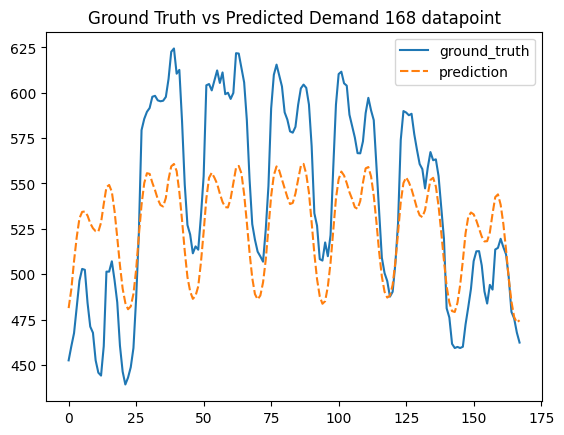

In [17]:
index = 100
ground_truth = y_test[index]
predicted_values = test_prediction[index]
mse, mape, mae = plot_truth_vs_pred(ground_truth, predicted_values, number_to_plot=168)
print(mse, mape, mae)

# Conclusion
### For 30 estimators graph,
* Ground truth vs predicted Demand in the index = 100
* mse, mape and mae = 1405.8141480158733 0.05897956063067388 31.288253968253965

### For 200 estimators graph
* Ground truth vs predicted Demand in the index = 100
* mse, mape and mae = 1621.530915934525 0.06597342711878049 35.993077380952414